In [232]:
import sys
sys.path.append('/Users/laurenthericourt/projets/trading/trading')

import psycopg2
import pandas as pd
from pandas.io.sql import read_sql
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from config.load import load_conf
from db.utils import get_uri_db
from strategy.examples.ema5_ema8 import Ema5Ema8
from utils.utils import AnnualGranularity, get_candles

In [2]:
load_conf('../config/configuration.yaml')
dsn = get_uri_db()
schema = 'trading'

# Get data

In [54]:
start_date = '2010-01-01'
end_date = '2021-01-01'

candles = get_candles(dsn, schema, start_date, end_date)

# Test_strategy

In [166]:
candles['symbol'].unique()

array(['AUD/USD', 'EUR/GBP', 'EUR/USD', 'GBP/USD', 'USD/CAD', 'USD/CHF',
       'USD/HKD', 'USD/JPY'], dtype=object)

In [242]:
candles_EURUSD = candles[(candles['table'] == 'candle30m') & (candles['symbol'] == 'EUR/USD')]

In [243]:
strat = Ema5Ema8(candles_EURUSD, AnnualGranularity.MIN_30.value, stop_loss_pips=5e-4, take_profits_pips=5e-3)

In [244]:
actions = strat.apply_strategy(update_stop_loss=False)

In [245]:
strat.compute_return()

<AxesSubplot:>

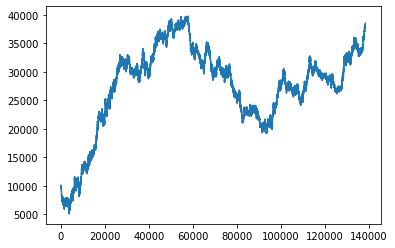

In [246]:
strat.data['return_cumsum'].plot()

In [165]:
strat.granularity = AnnualGranularity.MIN_30.value
strat.compute_performance()

In [148]:
strat.indicators

{'CAGR': 0.020138582055953202,
 'Volatility': 0.10131364395173012,
 'SharpeRatio': 0.14942293520866576,
 'Calmar': -0.007588541900779248}

# Show some data

In [13]:
strat.data[strat.data['action'] == 1].head()

,table,date,symbol,open,close,low,high,tickqty,macd,signal,hist_macd,macd_buy,macd_sell,slope_before,action,action_price,ret,stop_loss,take_profit,return,return_cumsum
11,candle4h,2020-06-10 00:00:00,EUR/USD,1.13327,1.13431,1.13327,1.13468,24761,0.001739,0.001555,0.000183,0,0,0.0,1,1.13431,0.00000,1.13277,1.14431,0.0,10000.0
37,candle4h,2020-06-16 00:00:00,EUR/USD,1.13383,1.13402,1.13282,1.13492,43308,-0.000217,-0.000921,0.000703,0,0,0.0,1,1.13402,0.00000,1.13232,1.14402,0.0,-103431.0
43,candle4h,2020-06-17 00:00:00,EUR/USD,1.12657,1.12650,1.12556,1.12739,45895,-0.000796,-0.000603,-0.000193,0,0,0.0,1,0.00000,1.12657,0.00000,0.00000,112657.0,-104176.0
65,candle4h,2020-06-22 08:00:00,EUR/USD,1.12111,1.12139,1.12039,1.12273,71101,-0.001848,-0.002138,0.000290,0,0,0.0,1,1.12139,0.00000,1.11989,1.13139,0.0,-104176.0
81,candle4h,2020-06-25 00:00:00,EUR/USD,1.12507,1.12427,1.12405,1.12603,41315,0.000621,0.001131,-0.000510,0,0,0.0,1,0.00000,1.12507,0.00000,0.00000,112507.0,-103808.0


In [14]:
strat.data.loc[:20, ['close', 'low', 'high', 'hist_macd', 'action', 'stop_loss', 'take_profit', 'ret', 'return_cumsum']]

,close,low,high,hist_macd,action,stop_loss,take_profit,ret,return_cumsum
0,1.13007,1.12817,1.13089,-4.818364e-04,0,0.00000,0.00000,0.00000,10000.0
1,1.12770,1.12688,1.13164,-6.256687e-04,0,0.00000,0.00000,0.00000,10000.0
2,1.12893,1.12763,1.13193,-6.314974e-04,0,0.00000,0.00000,0.00000,10000.0
3,1.12978,1.12861,1.13092,-5.728108e-04,0,0.00000,0.00000,0.00000,10000.0
4,1.13047,1.12902,1.13058,-4.850376e-04,0,0.00000,0.00000,0.00000,10000.0
5,1.12879,1.12847,1.13156,-5.248817e-04,0,0.00000,0.00000,0.00000,10000.0
6,1.12674,1.12558,1.12968,-6.634062e-04,0,0.00000,0.00000,0.00000,10000.0
7,1.12825,1.12415,1.12852,-6.384372e-04,0,0.00000,0.00000,0.00000,10000.0
8,1.13481,1.12802,1.13643,-2.024143e-04,0,0.00000,0.00000,0.00000,10000.0
9,1.13372,1.13333,1.13549,-4.350403e-07,0,0.00000,0.00000,0.00000,10000.0


In [60]:
strat.data['%50'] = strat.data.apply(axis=1, func=lambda x: int(x['return_cumsum'] % 50))

In [ ]:
strat.data

In [9]:
mask = (strat.data['high'] >= strat.data['previous_roll_max'])
strat.data[mask]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
949606,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308,0.005080,1.10536,1.07785,418308.0,candle1d,2020-02-27,EUR/USD,1.08870,1.09970,1.08854,1.10072,331934.0,0.004841,1.10486,1.07785,331934.0,0
949607,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988,0.005054,1.10745,1.07785,418308.0,candle1d,2020-02-28,EUR/USD,1.09970,1.10300,1.09516,1.10536,418308.0,0.005080,1.10536,1.07785,418308.0,0
949608,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031,0.005580,1.11853,1.07785,486031.0,candle1d,2020-03-01,EUR/USD,1.10300,1.10525,1.10300,1.10745,16988.0,0.005054,1.10745,1.07785,418308.0,0
949609,candle1d,2020-03-03,EUR/USD,1.11449,1.11772,1.10958,1.12140,509082,0.006132,1.12140,1.07785,509082.0,candle1d,2020-03-02,EUR/USD,1.10525,1.11449,1.10370,1.11853,486031.0,0.005580,1.11853,1.07785,486031.0,0
949611,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027,0.006802,1.12458,1.07785,509082.0,candle1d,2020-03-04,EUR/USD,1.11772,1.11390,1.10961,1.11881,342226.0,0.006343,1.12140,1.07785,509082.0,0
949612,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869,0.007220,1.13553,1.07785,580869.0,candle1d,2020-03-05,EUR/USD,1.11390,1.12233,1.11202,1.12458,307027.0,0.006802,1.12458,1.07785,509082.0,0
949613,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591,0.007488,1.13974,1.07785,580869.0,candle1d,2020-03-06,EUR/USD,1.12233,1.12892,1.12113,1.13553,580869.0,0.007220,1.13553,1.07785,580869.0,0
949614,candle1d,2020-03-09,EUR/USD,1.13884,1.13999,1.13568,1.14974,956742,0.008021,1.14974,1.07785,956742.0,candle1d,2020-03-08,EUR/USD,1.12892,1.13884,1.12892,1.13974,50591.0,0.007488,1.13974,1.07785,580869.0,0
949660,candle1d,2020-05-01,EUR/USD,1.09456,1.09846,1.09352,1.10196,222060,0.007317,1.10196,1.07276,390717.0,candle1d,2020-04-30,EUR/USD,1.08779,1.09456,1.08335,1.09735,390717.0,0.007230,1.09922,1.07276,390717.0,0
949682,candle1d,2020-05-27,EUR/USD,1.09791,1.10174,1.09343,1.10315,420202,0.006810,1.10315,1.07672,420202.0,candle1d,2020-05-26,EUR/USD,1.09023,1.09791,1.08973,1.09966,241409.0,0.006650,1.10091,1.07672,292042.0,0


In [18]:
strat.data[strat.data['action'] != 0]

,table,date,symbol,open,close,low,high,tickqty,atr,roll_max,roll_min,roll_max_vol,previous_table,previous_date,previous_symbol,previous_open,previous_close,previous_low,previous_high,previous_tickqty,previous_atr,previous_roll_max,previous_roll_min,previous_roll_max_vol,action
148323,candle,2020-01-03 07:15:00,EUR/USD,1.11639,1.11614,1.11607,1.11650,1168,0.000228,1.11722,1.11607,1381.0,candle,2020-01-03 07:10:00,EUR/USD,1.11713,1.11639,1.11637,1.11720,1381.0,0.000220,1.11722,1.11637,1381.0,-1
148333,candle,2020-01-03 08:05:00,EUR/USD,1.11570,1.11577,1.11566,1.11587,944,0.000307,1.11722,1.11526,2158.0,candle,2020-01-03 08:00:00,EUR/USD,1.11539,1.11570,1.11526,1.11595,2158.0,0.000306,1.11722,1.11526,2158.0,1
148417,candle,2020-01-03 15:05:00,EUR/USD,1.11565,1.11591,1.11541,1.11608,1933,0.000426,1.11679,1.11359,4124.0,candle,2020-01-03 15:00:00,EUR/USD,1.11529,1.11565,1.11529,1.11679,4124.0,0.000400,1.11679,1.11359,4124.0,1
148464,candle,2020-01-03 19:00:00,EUR/USD,1.11679,1.11656,1.11651,1.11689,1080,0.000237,1.11742,1.11651,1408.0,candle,2020-01-03 18:55:00,EUR/USD,1.11689,1.11679,1.11666,1.11694,459.0,0.000231,1.11742,1.11666,1408.0,-1
148826,candle,2020-01-07 00:05:00,EUR/USD,1.11944,1.11956,1.11944,1.11960,420,0.000112,1.11982,1.11938,577.0,candle,2020-01-07 00:00:00,EUR/USD,1.11961,1.11944,1.11938,1.11962,577.0,0.000109,1.11982,1.11938,577.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221931,candle,2020-12-23 01:40:00,EUR/USD,1.21796,1.21794,1.21785,1.21813,837,0.000427,1.21856,1.21547,2470.0,candle,2020-12-23 01:35:00,EUR/USD,1.21751,1.21796,1.21741,1.21796,943.0,0.000435,1.21880,1.21547,2470.0,1
221996,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985,0.000223,1.21906,1.21800,1489.0,candle,2020-12-23 07:00:00,EUR/USD,1.21845,1.21848,1.21800,1.21852,1489.0,0.000197,1.21905,1.21800,1489.0,-1
221997,candle,2020-12-23 07:10:00,EUR/USD,1.21903,1.21898,1.21893,1.21926,891,0.000232,1.21926,1.21800,1489.0,candle,2020-12-23 07:05:00,EUR/USD,1.21848,1.21903,1.21844,1.21906,985.0,0.000223,1.21906,1.21800,1489.0,1
222163,candle,2020-12-23 21:00:00,EUR/USD,1.21960,1.21916,1.21911,1.21963,1063,0.000373,1.21973,1.21740,1442.0,candle,2020-12-23 20:55:00,EUR/USD,1.21876,1.21961,1.21876,1.21973,1442.0,0.000363,1.21973,1.21732,1442.0,1
